<a href="https://colab.research.google.com/github/phylypo/TimeSeriesPrediction/blob/main/Time_Series_ML_LR_XGBoost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Overview of Time Series Forecasting from Statistical to Recent ML Approaches 

Topics for this notebook in bold:
- Introduction to TS
- Decompose (*Time_Series_FFT.ipynb*)
 - Gen Synthic
 - Decompose FFT
- Naive approaches
- Statistical (*Time_Series_ES_ARIMA.ipynb*)
 - Smoothing techniques
 - ARIMA
 - State Space (*Time_Series_StateSpace.ipynb*)
- **ML (*Time_Series_ML-LR_XGBoost.ipynb*)**
  - **Linear Regression**
  - **Decision Tree (XGBoost)**
- DL (*Time_Series_DL_LSTM_CNN.ipynb*)
 - LSTM, CNN + LSTM
 - TCN (*Time_Series_DL_TCN_LSTNet.ipynb*)
 - LSTNet
 - TFT (*Time_Series_DL_TFT_N-BEATS.ipynb*)
 - N-BEATS
- Commercial: (*Time_Series_Commercial.ipynb*)
 - Facebook Prophet
 - Amazon DeepAR

## ML: Classical Approaches
ML approaches was not developed specifically for time series, but we can make it accept time series data. Other models earlier was develop for temporal data/time series on their cores. We'll explore basic supervise learning techniques:

- Linear Regression
- Decision Tree with XGBoost (Gradient Boosted Tree) - showed great performance within Kaggle community

Shown in this chart, the topic will be discussing is the supervised learning technique under regression. That is under regression analysis and regression tree for XGBoost.

![](https://ars.els-cdn.com/content/image/1-s2.0-S157401372030071X-gr3.jpg)


### Generating Features
In earlier statistical approaches like ARIMA, the system was built for time series data. For ML, we need to generate features that the ML algorithms can use. Some of the features include:
- lags : value at time step t-N
- amplitude: amplitude from the mean value
- max/min value: max or min value at that window
- value > 1 std : count of value great than 1 standard deviation

![auto features gen](https://github.com/blue-yonder/tsfresh/raw/main/docs/images/introduction_ts_exa_features.png)

There is a library [cesium](https://github.com/cesium-ml/cesium) that provides features generation.


**We will just use lags values for our features.** To generate lag feature we just use the data and shift by one per each lag. For example for 3 features, we can use 3 lags value, lag_1: shift data by 1 and lag_2 shift by 2 and so forth.



In [ ]:
!curl -O https://assets.digitalocean.com/articles/eng_python/prophet/AirPassengers.csv

# load the dataset
from pandas import read_csv
series = read_csv('AirPassengers.csv', header=0, index_col=0)
values = series.values

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1748  100  1748    0     0  14096      0 --:--:-- --:--:-- --:--:-- 14096


In [ ]:
# Generate lags features

#https://machinelearningmastery.com/xgboost-for-time-series-forecasting/
import numpy as np
import pandas as pd
from pandas import read_csv
from pandas import concat

 
# transform a time series dataset into a supervised learning dataset
def gen_features(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values


# example feature gen
f = gen_features(values, n_in=12, dropnan=False)

np.set_printoptions(edgeitems=30, linewidth=1000, 
    formatter=dict(float=lambda x: "%.3g" % x))
print("Features:", f[0:15])

Time series:
 [[112]
 [118]
 [132]
 [129]
 [121]
 [135]
 [148]
 [148]
 [136]
 [119]
 [104]
 [118]
 [115]
 [126]
 [141]]


array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 112],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 112, 118],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, 112, 118, 132],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, 112, 118, 132, 129],
       [nan, nan, nan, nan, nan, nan, nan, nan, 112, 118, 132, 129, 121],
       [nan, nan, nan, nan, nan, nan, nan, 112, 118, 132, 129, 121, 135],
       [nan, nan, nan, nan, nan, nan, 112, 118, 132, 129, 121, 135, 148],
       [nan, nan, nan, nan, nan, 112, 118, 132, 129, 121, 135, 148, 148],
       [nan, nan, nan, nan, 112, 118, 132, 129, 121, 135, 148, 148, 136],
       [nan, nan, nan, 112, 118, 132, 129, 121, 135, 148, 148, 136, 119],
       [nan, nan, 112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104],
       [nan, 112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118],
       [112, 118, 132, 129, 121, 135, 148, 148, 136, 119, 104, 118, 115],
       [118, 132, 129, 121, 135, 148, 

### Linear Regression

In [ ]:
# https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
from pandas import read_csv
from sklearn import linear_model

# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an linear_reg_forecast model and make a one step prediction
def linear_reg_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	model = linear_model.LinearRegression()
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = linear_reg_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

>expected=417.0, predicted=395.3
>expected=391.0, predicted=393.8
>expected=419.0, predicted=424.9
>expected=461.0, predicted=423.5
>expected=472.0, predicted=488.1
>expected=535.0, predicted=506.1
>expected=622.0, predicted=612.7
>expected=606.0, predicted=607.8
>expected=508.0, predicted=532.1
>expected=461.0, predicted=439.6
>expected=390.0, predicted=422.5
>expected=432.0, predicted=421.8
MAE: 17.688


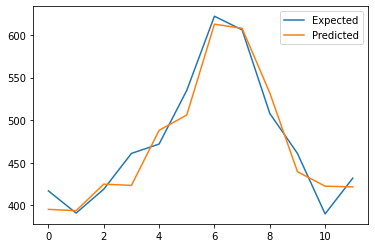

In [ ]:
# load the dataset
series = read_csv('AirPassengers.csv', header=0, index_col=0)
values = series.values

# transform the time series data into supervised learning
data = gen_features(values, n_in=12)

# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae) # MAE: 25.608
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

### XGBoost

In [ ]:
# forecast monthly births with xgboost
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from matplotlib import pyplot
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an xgboost model and make a one step prediction
def xgboost_forecast(train, testX):
	# transform list into array
	train = asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = XGBRegressor(objective='reg:squarederror', n_estimators=500) #1000
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict(asarray([testX]))
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = xgboost_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

>expected=417.0, predicted=384.8
>expected=391.0, predicted=403.8
>expected=419.0, predicted=459.7
>expected=461.0, predicted=437.5
>expected=472.0, predicted=465.7
>expected=535.0, predicted=506.3
>expected=622.0, predicted=550.9
>expected=606.0, predicted=617.6
>expected=508.0, predicted=494.8
>expected=461.0, predicted=457.5
>expected=390.0, predicted=452.8
>expected=432.0, predicted=431.4
MAE: 25.584


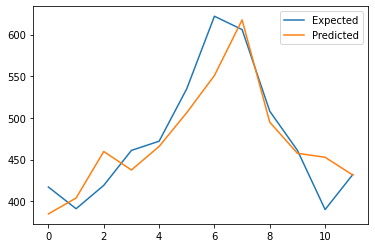

In [ ]:
# load the dataset
series = read_csv('AirPassengers.csv', header=0, index_col=0)
values = series.values

# transform the time series data into supervised learning
data = gen_features(values, n_in=12)

# evaluate
mae, y, yhat = walk_forward_validation(data, 12)
print('MAE: %.3f' % mae) # MAE: 25.608
# plot expected vs preducted
pyplot.plot(y, label='Expected')
pyplot.plot(yhat, label='Predicted')
pyplot.legend()
pyplot.show()

## Summary

In machine learning approach, required the input to be format into features. The typical linear regression is not that bad. XGBoost was used in Kaggle competition winner. 

Next notebook will cover the deep learning, the sequence to sequence approach like RNN and LSTM.